In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("factbook.db")
q = "select * from sqlite_master where type='table';"
cursor = conn.cursor()
cursor.execute(q).fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'facts',
  'facts',
  47,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float)')]

In [2]:
q5 = "select * from facts limit 5;"
#q5 = "Select * from facts where name = 'Antarctica';"
pd.read_sql_query(q5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [3]:
qminmax = "select MIN(population),MAX(population),MIN(population_growth),MAX(population_growth) from facts;"
#qminmax = "select MIN(population) from facts;"
pd.read_sql_query(qminmax, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


In [4]:
qextremes = "select * from facts where (population > 7e9 or population = 0)"# and name not in ('World', 'Antarctica');"
pd.read_sql_query(qextremes, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000.0,None,0,NaN,NaN,NaN,None
1,261,xx,World,None,NaN,None,7256490011,1.08,18.6,7.8,None


Two data points that fit the extremes in this scenario are 1) Antartica and 2) World.  Neither of these are countries, therefore don't necessarily fit in with our dataset.  

/Users/ChristianBarrera/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  # This is added back by InteractiveShellApp.init_path()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1171c4278>,
      dtype=object)

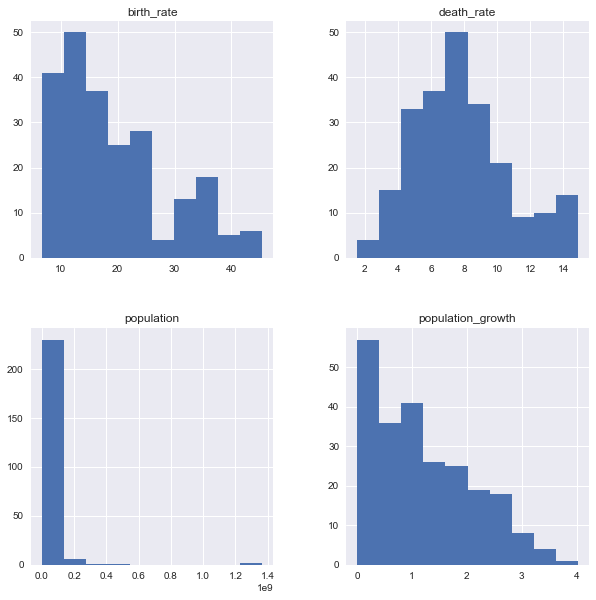

In [5]:
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

queue = '''select population, population_growth, birth_rate, death_rate from facts 
where name not in ('Antarctica', 'World');
'''
pd.read_sql_query(queue, conn).hist(ax=ax)

In [6]:
q_density = '''select name,population/area_land density from facts
order by density desc
'''
df = pd.read_sql_query(q_density, conn)
# print(df)

In [7]:
codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
# countries = df # Apply the country code to each country to make a 3-letter standard


extras = [] # create an empty list to add countries that don't align with a country code
new_data = pd.DataFrame(index=range(300),columns=['name', 'density', 'CODE'])

i = 0
for country in df['name']:
    row = df[df['name']==country].index[0]
    temp = codes[codes['COUNTRY']==country]
    try:    
        temp = temp['CODE'].iloc[0]  
        new_data.loc[i]['CODE'] = temp
        new_data.loc[i]['name'] = country
        new_data.loc[i]['density'] = df[df['name']==country]['density'].item()
        # print(country, df[df['name']==country]['density'].item(), temp)

        i += 1
    except IndexError:  # handle this error and add to the list of countries without a code
        extras.append(country)  # 'extras' is a list of countries that are not impactful enough for the final graph

new_data = new_data.drop(range(222,300))
print("--NEW--\n", new_data)


/Users/ChristianBarrera/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: `item` has been deprecated and will be removed in a future version
  app.launch_new_instance()


--NEW--
                                   name density CODE
0                                Macau   21168  MAC
1                               Monaco   15267  MCO
2                            Singapore    8259  SGP
3                            Hong Kong    6655  HKG
4                            Gibraltar    4876  GIB
..                                 ...     ...  ...
217                          Greenland       0  GRL
218  Falkland Islands (Islas Malvinas)       0  FLK
219                           Ethiopia     NaN  ETH
220                        South Sudan     NaN  SSD
221                              Sudan     NaN  SDN

[222 rows x 3 columns]


In [8]:
# Last three rows are junk because the land area data is missing.  Drop last three rows

df = new_data.drop(range(219,222))
print(df)


                                  name density CODE
0                                Macau   21168  MAC
1                               Monaco   15267  MCO
2                            Singapore    8259  SGP
3                            Hong Kong    6655  HKG
4                            Gibraltar    4876  GIB
..                                 ...     ...  ...
214                          Australia       2  AUS
215                            Namibia       2  NAM
216                           Mongolia       1  MNG
217                          Greenland       0  GRL
218  Falkland Islands (Islas Malvinas)       0  FLK

[219 rows x 3 columns]


In [9]:
import plotly.graph_objects as go
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

fig = go.Figure(data=go.Choropleth(
    locations = df['CODE'],
    z = df['density'],
    text = df['name'],
    colorscale = 'sunset', 
    autocolorscale=False,
#     tick0 = '1',
    showscale=True,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.2,
    #colorbar_title = 'Universities in top 500',
    #hovertext = countries['COUNTRY'] + countries['SCHOOLS'],
))

fig.update_layout(
    title_text='Population Density',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://github.com/factbook/factbook.sql/releases">\
            Factbook</a>',
        showarrow = False
    )]
)

# fig.show()
iplot(fig)

#### From the above model, we can see that everything looks the same.  Let's fix this problem by ridding the dataset of the city-states with large population densities that lie in the extreme.  We'll start with Bangladesh -- a sizable country with the largest population density.  

In [10]:
# Bangladesh index starts at 9
try:
    df = df.drop(range(0,9))
except ValueError:
    print("Already cleaned!")
print(df.head(15))

            name density CODE
9     Bangladesh    1297  BGD
10  Sint Maarten    1167  SXM
11      Guernsey     847  GGY
12        Jersey     838  JEY
13        Taiwan     725  TWN
14      Barbados     675  BRB
15     Mauritius     660  MUS
16         Aruba     623  ABW
17       Lebanon     604  LBN
18  Saint Martin     588  MAF
19    San Marino     541  SMR
20        Rwanda     513  RWA
21  Korea, South     506  KOR
22   Netherlands     500  NLD
23     West Bank     493  WBG


In [12]:
import plotly.graph_objects as go
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import chart_studio.plotly as py
init_notebook_mode(connected=True)

fig = go.Figure(data=go.Choropleth(
    locations = df['CODE'],
    z = df['density'],
    text = df['name'],
    colorscale = 'sunset', 
    autocolorscale=False,
#     tick0 = '1',
    showscale=True,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.2,
    colorbar_title = 'Density ppl/km^2',
))

fig.update_layout(
    title_text='Population Density',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://github.com/factbook/factbook.sql/releases">\
            Factbook</a>',
        showarrow = False
    )]
)

# fig.show()
iplot(fig)
py.iplot(fig, filename='World Population Density')

Results:  Bangladesh, South Korea, Lebanon, Netherlands, and India are among the highest populated areas in the world.  Parts of Western Europe are very dense as well, and can be seen even on any smartphone map with roads and structures everywhere!  

Note:  There are some missing data points (i.e. Sudan, South Sudan, Ethiopia) because of missing data on land area, therefore a density could not be concluded.  

Extra:  Figure out a way to make the colormap logarithmic so that the extremes don't skew the map into showing that the United States and Honduras have a close population density based on color (35 vs 78).  